# **Implementação de tecnicas e Algortimos para seleção de variáveis mais preditivas**

In [284]:
# Imports necessários
import pandas as pd
import numpy as np
import sklearn
# métricas de avaliação de performance dos modelos
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report,auc
from sklearn.metrics import ConfusionMatrixDisplay

# otimização dos modelos
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Preditores para importância das variáveis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Parâmetros de otimização
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Plote grafico
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
import plotly.express as px
import shap # Valores de importância  Shapley Baseado na teoria dos jogos
shap.initjs()



## Banco de dados "heart.csv"


## descrição das variáveis

Age: Refere-se a idade do(a) Paciente

Sex: indica o sexo do paciente M(masculinio) F(feminino)

ChestPainType: refere-se ao tipo de dor no peito (TA: Angina tipica, ATA: Angina atipica, NAP: Dor não anginal
                ASY: Assintomático.
                
RestingBP: Pressão sanguínea em repouso em mmHg

Cholesterol: Colesterol seríco em mm/dl

FastingBS: açúcar no sangue em jejum (mg/dl) 0: Fasting BS < 120 mg/dl (não diabético) 1: Fasting BS >= 120 mg/dl, (diabético)

RestingECG: resultados de eletrocardiogramas em repouso (Normal: Normal, ST: tendo ondas ST-T  anormais    LVH: mostrando provável ou hipertrofia ventricular esquerda.  

MaxHR: maxímo de batimentos cardiacos alcançados (valores númericos  entre 60 e 202)

ExerciseAngina: Angina induzida por exercícios - variável Dummie (Y: Sim, N: Não)

Oldpeak: oldpeak = ST (valor númerico medido na depressão gráfica)

ST_Slope: the slope of the peak exercise ST segment (Up, Flat, Down)

HeartDisease: Doença cardíaca (0=Não possui doença cardíaca; 1=Possui doença cardíaca)



In [286]:
# Carregar os dados com o separador correto (ponto e vírgula)
coracao = pd.read_csv(r'\heart_tratado.csv', sep=';')


# Verificar o formato e as primeiras linhas dos dados
print(coracao.shape)
print(coracao.head())

# Importar o Counter corretamente
from collections import Counter

# Contar a ocorrência de valores na coluna 'HeartDisease', seria a saída Tem ou não tem doença cardiaca
print(Counter(coracao['HeartDisease']))

# Análise exploratória dos dados
coracao.describe()



(917, 12)
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140        289.0          0     Normal    172   
1   49   F           NAP        160        180.0          0     Normal    156   
2   37   M           ATA        130        283.0          0         ST     98   
3   48   F           ASY        138        214.0          0     Normal    108   
4   54   M           NAP        150        195.0          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
Counter({1: 507, 0: 410})


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,53.509269,132.540894,244.635389,0.233370,136.789531,0.886696,0.552890
std,9.437636,17.999749,53.347125,0.423206,25.467129,1.066960,0.497466
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,244.635389,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


##  Verificação por valores Faltantes

In [9]:
coracao.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

otimo não há dados faltando :D

## Separando variáveis númericas das categoricas

In [289]:
coracao2 = coracao.copy(deep = True)
dados_numericos = coracao2.select_dtypes(include=[np.number])
dados_numericos.drop(["FastingBS","HeartDisease"],axis=1,inplace=True)
print(dados_numericos.columns)
dados_categoricos = coracao2.select_dtypes(exclude=[np.number])
dados_categoricos["FastingBS"]=coracao2["FastingBS"]
print(dados_categoricos.columns)
for col in dados_categoricos:
    print(Counter(coracao2[col]))  


Index(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'], dtype='object')
Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope',
       'FastingBS'],
      dtype='object')
Counter({'M': 724, 'F': 193})
Counter({'ASY': 496, 'NAP': 202, 'ATA': 173, 'TA': 46})
Counter({'Normal': 551, 'LVH': 188, 'ST': 178})
Counter({'N': 546, 'Y': 371})
Counter({'Flat': 459, 'Up': 395, 'Down': 63})
Counter({0: 703, 1: 214})


## One hot encoding  - Transforma Variáveis Categoricas em um formato númerico, por meio de posto sem hierarquia

In [291]:
coracao2 = pd.get_dummies(coracao, columns=['Sex', 'ChestPainType', 'RestingECG','ExerciseAngina',\
                                        'ST_Slope'])

## Mapa de correlação

<Axes: >

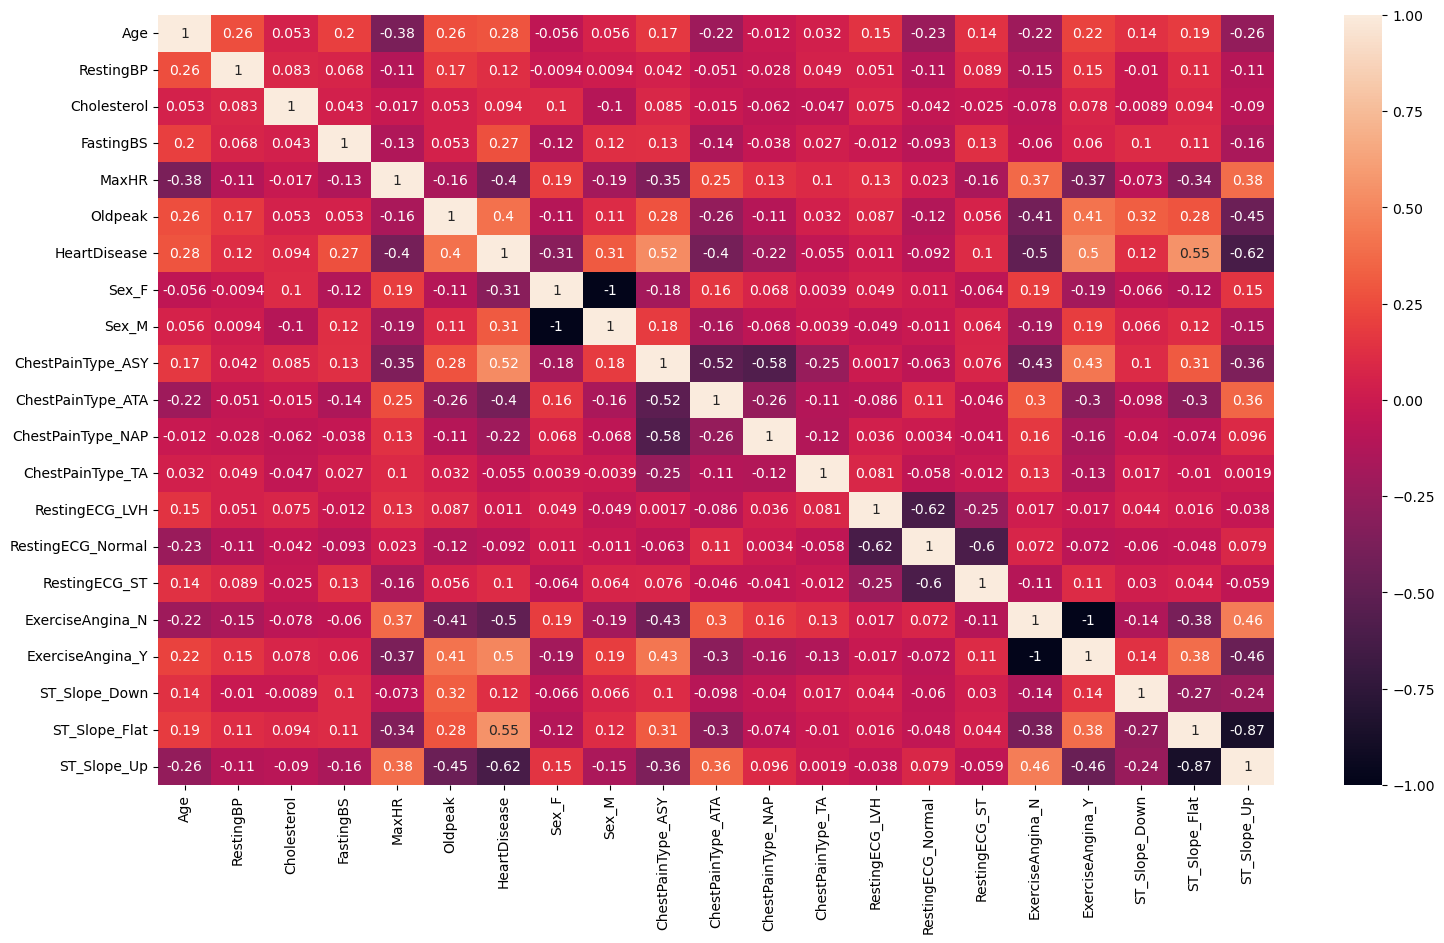

In [293]:
corr = coracao2.corr()
plt.figure(figsize = (18,10))
sns.heatmap(corr,annot=True, )

Pela visualização, a maioria das correlações parece estar entre -0.5 e 0.5, o que sugere que as variáveis não estão fortemente correlacionadas. Algumas variáveis têm correlações moderadas (como a relação entre Oldpeak e ST_Slope_Up, que parece ter uma correlação negativa forte), mas não há muitas relações extremamente altas ou baixas que indiquem multicolinearidade severa.

# VIF serve para averiguar multicolinearidade entre variáveis valores > 5 existe certo grau de colinearidade entre variáveis

In [295]:

from statsmodels.stats.outliers_influence import variance_inflation_factor


# Remover a variável alvo (assumindo que a coluna alvo é 'target', ajuste conforme necessário)
X = coracao2.drop(columns=['target'], errors='ignore')

# Selecionar apenas variáveis numéricas
X = X.select_dtypes(include=['number'])

# Criar um DataFrame para armazenar os valores de VIF
vif_data = pd.DataFrame()
vif_data["Variável"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Exibir os resultados
print(vif_data)


       Variável        VIF
0           Age  32.372436
1     RestingBP  46.959607
2   Cholesterol  20.482810
3     FastingBS   1.435989
4         MaxHR  21.930320
5       Oldpeak   2.084293
6  HeartDisease   3.208269


Variáveis como AGE,RestingBP, Cholesterol, MAXHR apresentam alta correlação, podem ser candidatas a exclusão a seguir será feitos os diversos métodos de análise de importância de variáveis

# -----------------------------------------------------

# Criação de conjuntos de dados de treinamento e teste

#  criando X e y

In [304]:
X = coracao2.drop('HeartDisease',axis=1)
y = coracao2['HeartDisease']
# Coletando o nome das variáveis para uso futuro
variaveis = list(X.columns.values)
print("O cabeçalho da coluna:", variaveis)

O cabeçalho da coluna: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']


### Mutual info para variáveis

[0.0523912  0.02356653 0.07288474 0.05510313 0.08315484 0.12432096
 0.05779116 0.06431392 0.13969922 0.09517311 0.01182156 0.
 0.01717721 0.         0.01986745 0.14567311 0.12142671 0.
 0.14641907 0.20794323]


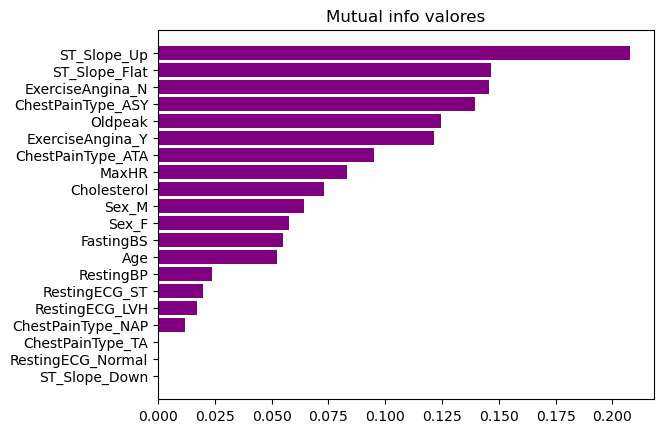

In [306]:
from sklearn.feature_selection import mutual_info_classif as MIC
mi_val = MIC(X, y)
print(mi_val)

# Cria uma Série com os valores da informação mútua e o nome das variáveis
mut_val = pd.Series(mi_val, index=variaveis)

# Ordena os índices pela informação mútua
indices_arrumados = np.argsort(mut_val)

# Cria o gráfico de barras horizontais
plt.title('Mutual info valores')
plt.barh(range(len(indices_arrumados)), mut_val.iloc[indices_arrumados], color='purple', align='center')
plt.yticks(range(len(indices_arrumados)), [variaveis[i] for i in indices_arrumados])
plt.show()


As variáveis no topo indicam  uma forte relação com a variável alvo. Ou seja, essas variáveis carregam uma grande quantidade de informação que pode ser útil para prever a variável dependente (infarte ou não infarte)

### Dividir em conjunto de treinamento e teste usando Stratify

In [310]:
# Stratify garante a distribuição das classes na variável y seja preservada, ou seja a mesma proporção de
# Classes para teste e treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42, stratify=y)

# copia do treino original sendo feito caso for necessário para comparações ou verificação futuras
# Isso é necessário Conversão de y_train e y_test de Series para ndarray para o pacote que precisa de uma série como entrada.
y_trainorig=y_train

# # ISSO É NECESSÁRIO PARA A FUNÇÃO FIT DOS ESTIMADORES. A SÉRIE PRECISA SER CONVERTIDA PARA
#A MATRIZ 1-D.

# estimadores do scikit-learn, como regressões e classificações, exigem que os dados de entrada estejam no formato NumPy.
y_train= y_train.to_numpy()
y_test= y_test.to_numpy()


# Escalando os dados - Padronização

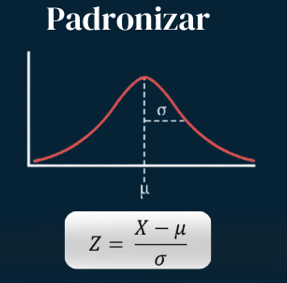

StandardScaler efetuará padronização (dos valores númericos )esse método realiza a transformação das colunas para terem média 0 e desvio padrão 1.

In [312]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler() # padronização

# Padronizando as variáveis numéricas de Treinamento
X_train['Oldpeak'] = ss.fit_transform(X_train[['Oldpeak']])
X_train['Age'] = ss.fit_transform(X_train[['Age']])
X_train['RestingBP'] = ss.fit_transform(X_train[['RestingBP']])
X_train['Cholesterol'] = ss.fit_transform(X_train[['Cholesterol']])
X_train['MaxHR'] = ss.fit_transform(X_train[['MaxHR']])
X_trainD=pd.DataFrame(X_train)
print(X_trainD.head())

# Padronizando as variáveis numéricas de Teste
X_test['Oldpeak'] = ss.fit_transform(X_test[['Oldpeak']])
X_test['Age'] = ss.fit_transform(X_test[['Age']])
X_test['RestingBP'] = ss.fit_transform(X_test[['RestingBP']])
X_test['Cholesterol'] = ss.fit_transform(X_test[['Cholesterol']])
X_test['MaxHR'] = ss.fit_transform(X_test[['MaxHR']])
X_testD=pd.DataFrame(X_test)
print(X_testD.head())


          Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak  Sex_F  \
53  -1.350203  -0.133297    -0.002373          0  0.532580 -0.802872   True   
336  1.933272   1.463142    -0.009282          0 -0.880135  0.664827  False   
135 -0.502854  -0.931516     0.376593          0  1.513633 -0.802872  False   
630 -0.820610   0.398850     1.248214          0 -0.644682  0.848289  False   
863  0.662250   0.664923     0.698714          0  0.218644  1.765601  False   

     Sex_M  ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  \
53   False              False               True              False   
336   True              False              False               True   
135   True              False              False               True   
630   True               True              False              False   
863   True               True              False              False   

     ChestPainType_TA  RestingECG_LVH  RestingECG_Normal  RestingECG_ST  \
53              False  

# -------------------------------------------------------------

# O CÁLCULO DE MODELAGEM E IMPORTÂNCIA DE RECURSOS COMEÇA AQUI

# Importância de variáveis usando técnicas de interpretação

## Seleção de recursos usando SelectKBest


Seleção K-Best: Seleção K-Best: Método de seleção de variáveis que escolhe as k melhores características com base em testes estatísticos, como qui-quadrado (para variáveis categóricas) ou ANOVA (para variáveis numéricas), medindo a relação entre cada variável independente e a variável alvo.

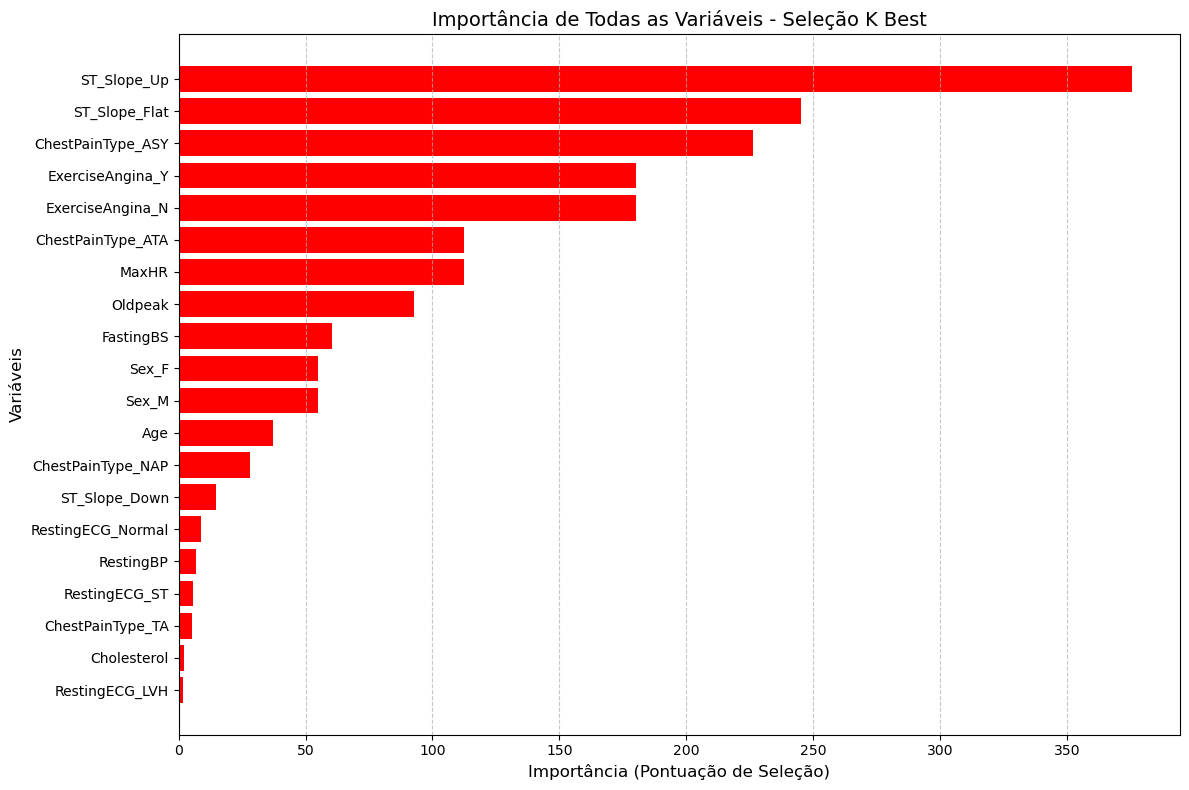

In [314]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split


# Realizando a seleção das melhores características com SelectKBest
f_selector = SelectKBest(score_func=f_classif, k='all')  # Selecionar todas as características
f_selector.fit(X_train, y_train)

# Obter todas as variáveis e suas pontuações
feature_scores = f_selector.scores_

# Ordenando as características com base na pontuação de seleção
sorted_idx = np.argsort(feature_scores)[::-1]  # Ordenar por importância (pontuação) decrescente
sorted_features = np.array(X_train.columns)[sorted_idx]
sorted_scores = feature_scores[sorted_idx]

# Plotando a importância das variáveis
plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_scores, color='red', align='center')
plt.xlabel('Importância (Pontuação de Seleção)', fontsize=12)
plt.ylabel('Variáveis', fontsize=12)
plt.title('Importância de Todas as Variáveis - Seleção K Best', fontsize=14)
plt.gca().invert_yaxis()  # Inverter o eixo Y para que a maior importância fique no topo
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Exibindo o gráfico
plt.tight_layout()
plt.show()


## TÉCNICAS DE SELEÇÃO COM FILTROS INCORPORADOS

### regressão logística

Regressão Logística: Modelo estatístico que estima a probabilidade de um evento ocorrer com base nas variáveis preditoras, atribuindo coeficientes que indicam a influência de cada variável na previsão do resultado.

In [316]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# Criando e treinando o modelo de Regressão Logística
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# Fazendo previsões
y_pred = log_model.predict(X_test)

# Avaliação do modelo
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusão:")
print(conf_matrix)

# Exibindo os coeficientes e as variáveis associadas
coef_df = pd.DataFrame(log_model.coef_[0], X_train.columns, columns=['coef'])
print("\nCoeficientes das Variáveis:")
print(coef_df.sort_values(by='coef', ascending=False))


Acurácia: 0.8811881188118812
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.88      0.85      0.86       135
           1       0.88      0.90      0.89       168

    accuracy                           0.88       303
   macro avg       0.88      0.88      0.88       303
weighted avg       0.88      0.88      0.88       303


Matriz de Confusão:
[[115  20]
 [ 16 152]]

Coeficientes das Variáveis:
                       coef
FastingBS          1.345661
ChestPainType_ASY  1.290776
ST_Slope_Flat      0.846572
Sex_M              0.643264
ExerciseAngina_Y   0.350012
Oldpeak            0.332368
ST_Slope_Down      0.309651
RestingECG_LVH     0.240927
Cholesterol        0.094806
Age                0.037281
RestingBP         -0.034049
RestingECG_ST     -0.082252
RestingECG_Normal -0.165359
ChestPainType_NAP -0.322395
ExerciseAngina_N  -0.356696
MaxHR             -0.358784
ChestPainType_TA  -0.480775
ChestPainType_ATA -0.494291
Sex_F     

# Classificador Random Forest

Random Forest Feature Importance: Mede a importância das variáveis em um modelo Random Forest analisando a redução da impureza (exemplo: Gini ou entropia) ao longo das divisões nas árvores de decisão, ou pela diminuição da acurácia ao permutar aleatoriamente os valores das variáveis.


Acurácia: 0.8976897689768977
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88       135
           1       0.91      0.91      0.91       168

    accuracy                           0.90       303
   macro avg       0.90      0.90      0.90       303
weighted avg       0.90      0.90      0.90       303



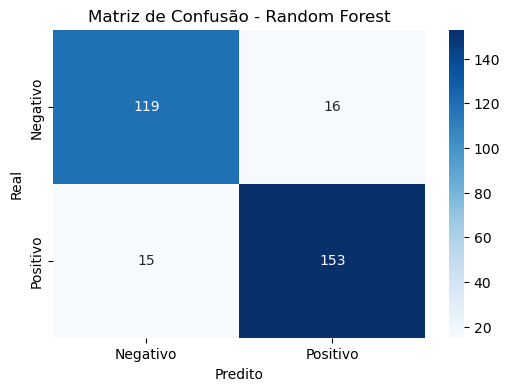

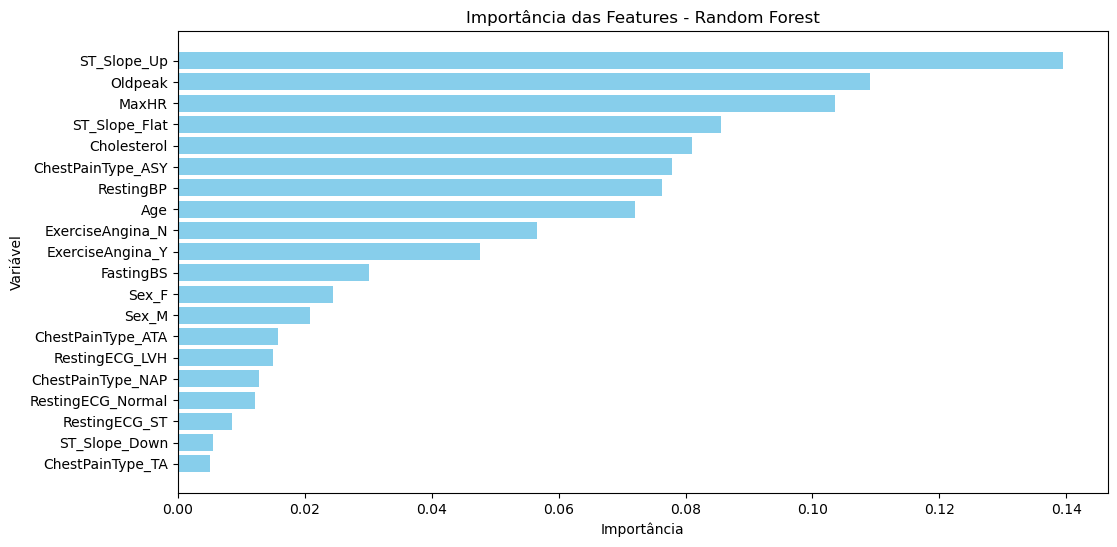

In [318]:
# Criando e treinando o modelo Random Forest (sem "FastingBS")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Fazendo previsões
y_pred_rf = rf_model.predict(X_test)

# Avaliação do modelo
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_rf))

# Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Random Forest")
plt.show()

# Importância das Features
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Criar um DataFrame para organizar as importâncias
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotando as importâncias das features
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.title("Importância das Features - Random Forest")
plt.gca().invert_yaxis()  # Inverter para mostrar a maior importância no topo
plt.show()


# LightGBM

LightGBM: Algoritmo baseado em gradient boosting que utiliza histogramas para acelerar a busca por divisões ótimas, atribuindo importância às variáveis com base no ganho de informação que elas proporcionam durante o treinamento do modelo.

Melhores parâmetros encontrados pelo GridSearchCV: {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 50}
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       135
           1       0.90      0.89      0.89       168

    accuracy                           0.88       303
   macro avg       0.88      0.88      0.88       303
weighted avg       0.88      0.88      0.88       303

Matriz de Confusão
[[118  17]
 [ 19 149]]


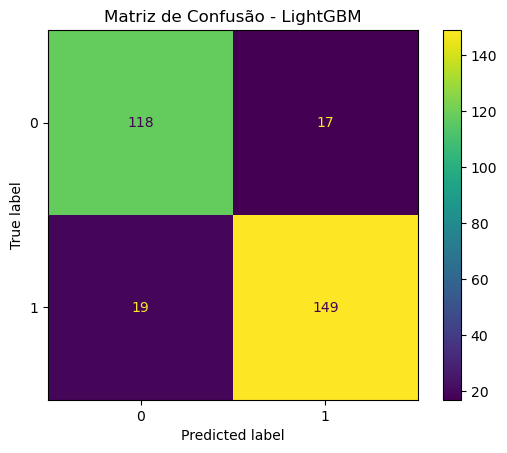

Acurácia: 0.8811881188118812
AUC: 0.92989417989418


In [352]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Definindo o modelo base do LightGBM com verbose=-1
gbe = lgb.LGBMClassifier(verbose=-1)

# Definindo os parâmetros para a busca em grid
boosted_grid = {'n_estimators': [50, 100, 150, 200],
                'max_depth': [4, 8, 12],
                'learning_rate': [0.05, 0.1, 0.15]}

# Executando a busca em grid com verbose=0 para GridSearchCV
CV_gbe = GridSearchCV(estimator=gbe, param_grid=boosted_grid, cv=5, verbose=0)
CV_gbe.fit(X_train, y_train)

# Exibindo os melhores parâmetros
print("Melhores parâmetros encontrados pelo GridSearchCV:", CV_gbe.best_params_)

# Ajustando o modelo LightGBM com os melhores parâmetros
model_lgb = lgb.LGBMClassifier(device="gpu", 
                               learning_rate=CV_gbe.best_params_['learning_rate'],
                               max_depth=CV_gbe.best_params_['max_depth'],
                               n_estimators=CV_gbe.best_params_['n_estimators'],
                               verbose=-1)  # Minimizando a verbosidade durante o treinamento

model_lgb.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
predicted_lgb = model_lgb.predict(X_test)

# Avaliação do modelo
print("CLASSIFICATION REPORT")
print(classification_report(y_test, predicted_lgb))

# Matriz de Confusão
print("Matriz de Confusão")
cm_lgb = confusion_matrix(y_test, predicted_lgb)
print(cm_lgb)

# Exibindo a matriz de confusão como um gráfico
disp_lgb = ConfusionMatrixDisplay(confusion_matrix=cm_lgb, display_labels=model_lgb.classes_)
disp_lgb.plot()
plt.title('Matriz de Confusão - LightGBM')
plt.show()

# Acurácia
accuracy = accuracy_score(y_test, predicted_lgb)
print('Acurácia:', accuracy)

# Curva ROC e AUC
arr_predicted_probs = model_lgb.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva
fpr, tpr, thresholds = roc_curve(y_test, arr_predicted_probs, pos_label=1)

roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)



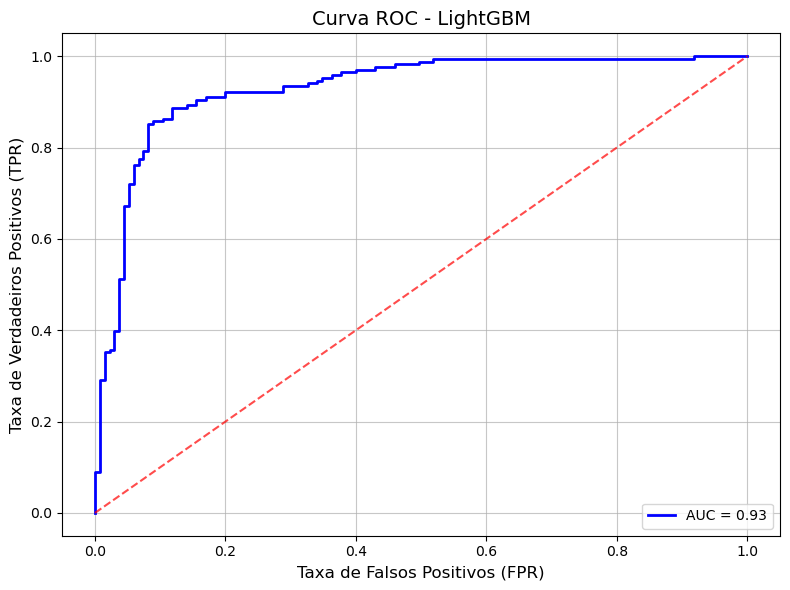

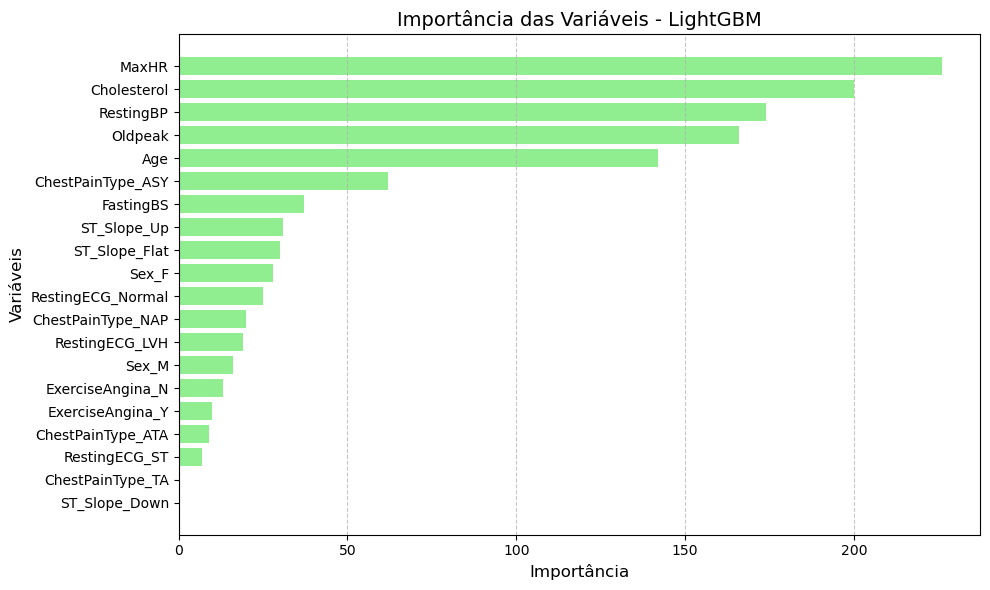

In [354]:
# Plotando a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', alpha=0.7)  # Linha diagonal
plt.title('Curva ROC - LightGBM', fontsize=14)
plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(alpha=0.7)
plt.tight_layout()
plt.show()

# Plotando a importância das variáveis utilizando gráfico de barras horizontais (barh)
importances = model_lgb.feature_importances_
features = X_train.columns

# Criando um DataFrame com a importância e as variáveis
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Plotando
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightgreen')
plt.xlabel('Importância', fontsize=12)
plt.ylabel('Variáveis', fontsize=12)
plt.title('Importância das Variáveis - LightGBM', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# XGBOOST

Método avançado de gradient boosting que calcula a importância das variáveis avaliando o ganho de informação, a cobertura (quantidade de amostras impactadas) e a frequência com que cada variável é usada para dividir os nós das árvores.

C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:27:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ROC AUC Score: 0.9288


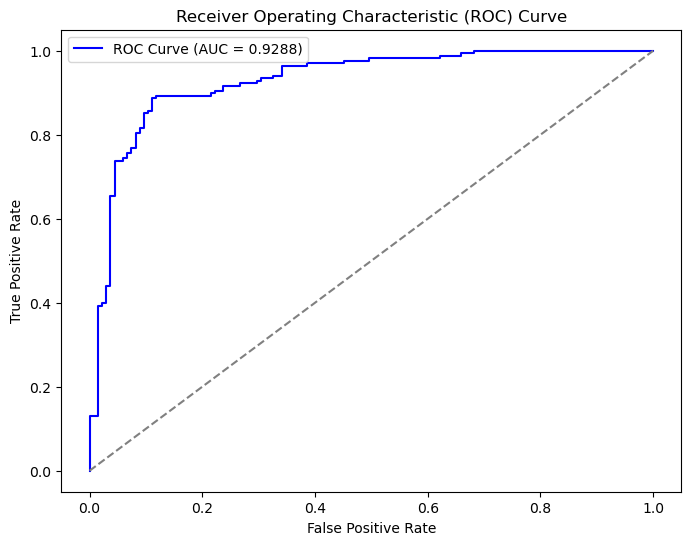

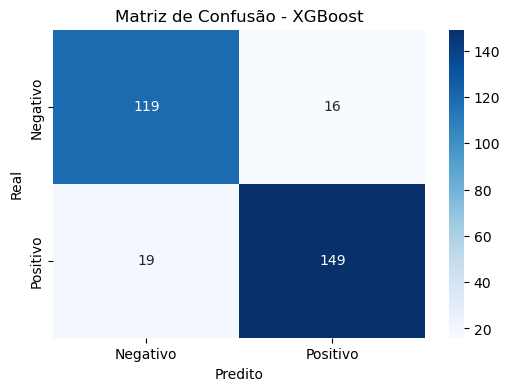

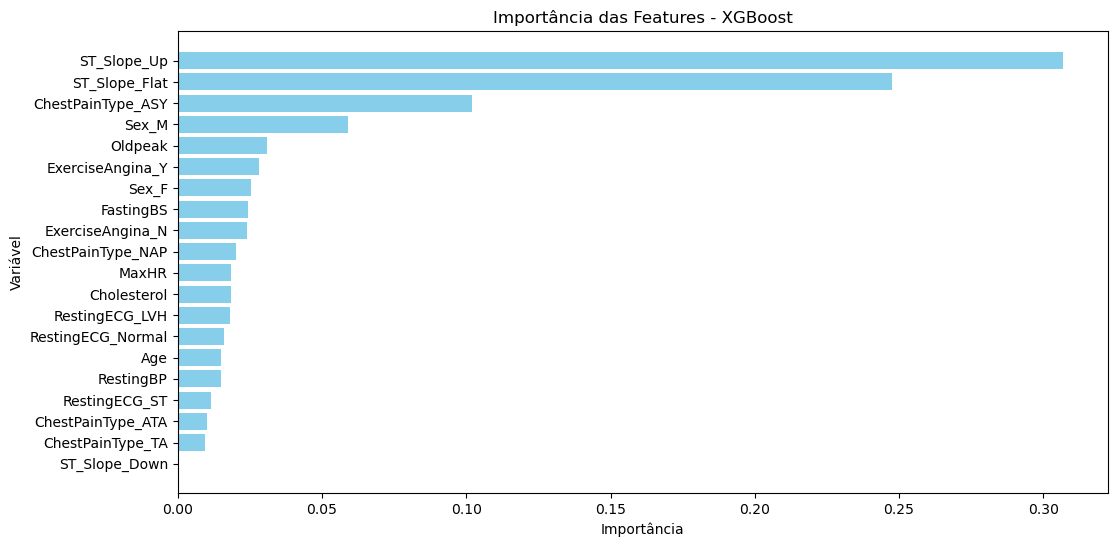

In [320]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Definição dos hiperparâmetros
params = {
    'max_depth': 6,
    'gamma': 1,
    'reg_lambda': 0.5,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'n_estimators': 180,
    'eval_metric': "auc",
    'use_label_encoder': False,
    'seed': 0
}

# Treinamento do modelo
model = XGBClassifier(**params)
model.fit(X_train, y_train)

# Previsão e cálculo do ROC AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plotando a curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - XGBoost")
plt.show()

# Obtendo a importância das features
importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotando a importância das features
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.title("Importância das Features - XGBoost")
plt.gca().invert_yaxis()  # Inverter para mostrar a maior importância no topo
plt.show()

# Catboost

CatBoost: Algoritmo de gradient boosting otimizado para variáveis categóricas, calculando a importância das variáveis com base no ganho de informação em cada divisão das árvores e na redução do erro do modelo. Usa ordered boosting para evitar viés e melhorar a generalização.

ROC AUC Score: 0.9431


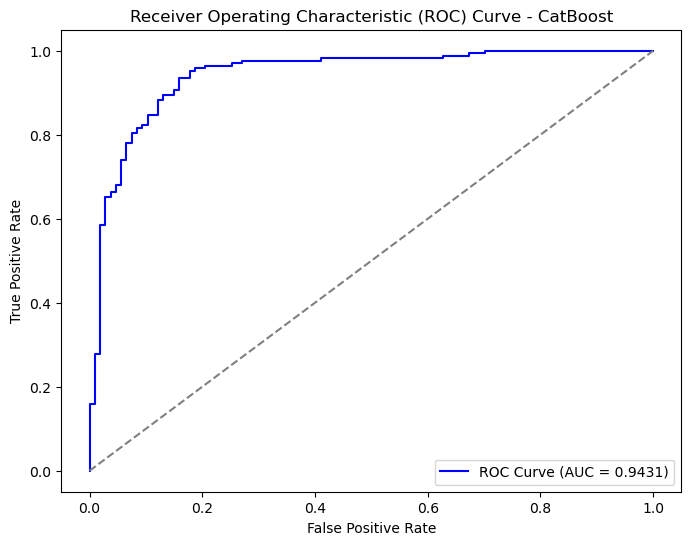

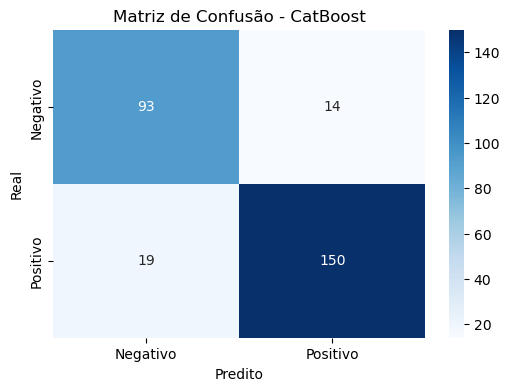

CatBoost Classification Report
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       107
           1       0.91      0.89      0.90       169

    accuracy                           0.88       276
   macro avg       0.87      0.88      0.88       276
weighted avg       0.88      0.88      0.88       276

CatBoost Accuracy: 0.8804


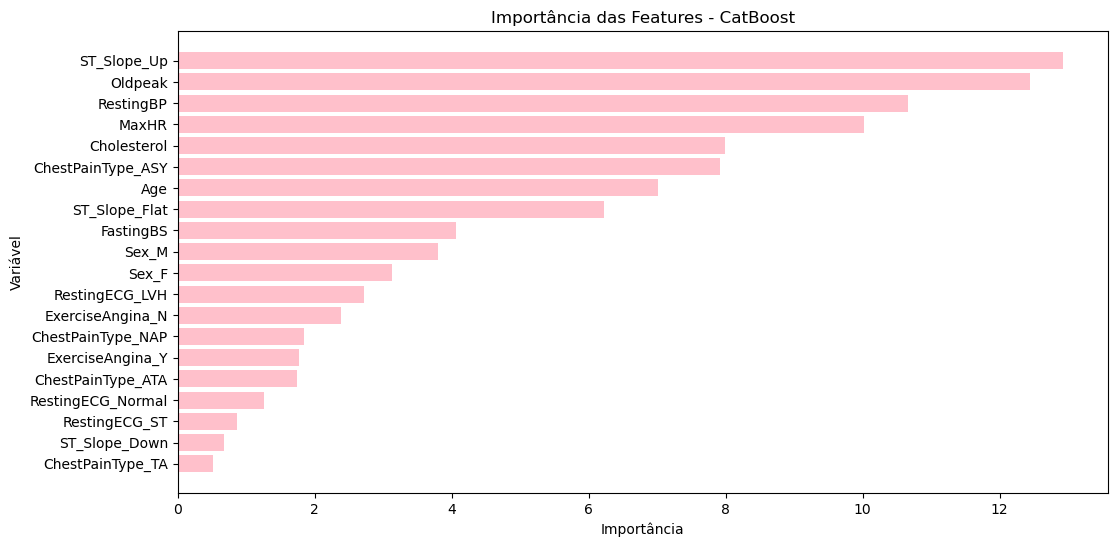

In [322]:
# Separando as variáveis independentes (X) e dependentes (y)
Xcat = coracao2.drop('HeartDisease', axis=1)  # 'HeartDisease' é a variável alvo
ycat = coracao2['HeartDisease']  # Alvo (target)

# Dividindo os dados em treino e teste
Xcat_train, Xcat_test, ycat_train, ycat_test = train_test_split(Xcat, ycat, test_size=0.3, random_state=42)

# Ajustando formato dos rótulos
ycat_train = ycat_train.values.reshape(-1, 1)
ycat_test = ycat_test.values.reshape(-1, 1)

# Modelando com CatBoost
model_cat = cb.CatBoostClassifier(loss_function="Logloss", iterations=1000, eval_metric="AUC")
model_cat.fit(Xcat_train, ycat_train, verbose=0)

# Previsão e cálculo do ROC AUC
y_pred_proba_cat = model_cat.predict_proba(Xcat_test)[:, 1]
y_pred_cat = model_cat.predict(Xcat_test)
roc_auc_cat = roc_auc_score(ycat_test, y_pred_proba_cat)
print(f"ROC AUC Score: {roc_auc_cat:.4f}")

# Plotando a curva ROC
fpr, tpr, _ = roc_curve(ycat_test, y_pred_proba_cat)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {roc_auc_cat:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - CatBoost')
plt.legend()
plt.show()

# Matriz de Confusão
conf_matrix_cat = confusion_matrix(ycat_test, y_pred_cat)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_cat, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - CatBoost")
plt.show()

# Relatório de Classificação
print("CatBoost Classification Report")
print(classification_report(ycat_test, y_pred_cat))

# Acurácia
accuracy_cat = accuracy_score(ycat_test, y_pred_cat)
print(f'CatBoost Accuracy: {accuracy_cat:.4f}')

# Importância das Features
importances_cat = model_cat.feature_importances_
feature_importance_df_cat = pd.DataFrame({'Feature': Xcat.columns, 'Importance': importances_cat})
feature_importance_df_cat = feature_importance_df_cat.sort_values(by='Importance', ascending=False)

# Plotando a importância das features
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df_cat['Feature'], feature_importance_df_cat['Importance'], color='pink')
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.title("Importância das Features - CatBoost")
plt.gca().invert_yaxis()
plt.show()


## Seleção por Boruta

In [348]:
from boruta import BorutaPy
import numpy as np

# Inicializando o BorutaPy com o modelo e max_iter configurado
boruta = BorutaPy(estimator=model_rf, n_estimators='auto', max_iter=50, random_state=42)

# Ajustando o Boruta nos dados de treino
boruta.fit(np.array(X_train), np.ravel(y_train))

# Obtendo as features selecionadas
green_area = X.columns[boruta.support_].to_list()

# Exibindo as features selecionadas
print('Selected Features:', green_area)


Selected Features: ['Cholesterol', 'MaxHR', 'Oldpeak', 'ChestPainType_ASY', 'ExerciseAngina_N', 'ST_Slope_Flat', 'ST_Slope_Up']
